<a href="https://colab.research.google.com/github/Anish32/uber-prediction/blob/main/uber_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import math
import scipy
from tqdm import tqdm
from IPython.display import display

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df= pd.read_csv('/content/uber.csv')

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [4]:
df = df.drop(["Unnamed: 0"],axis=1)

In [5]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [6]:
target = df["fare_amount"]
features = df.drop(["fare_amount"],axis = 1)

In [7]:
target.head()

,fare_amount
0,7.5
1,7.7
2,12.9
3,5.3
4,16.0


In [8]:
features.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,2009-07-17 20:04:56.0000002,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,2009-08-24 21:45:00.00000061,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,2009-06-26 08:22:21.0000001,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,2014-08-28 17:47:00.000000188,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [9]:
df.shape

(35725, 8)

In [10]:
df.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,1
pickup_latitude,1
dropoff_longitude,1
dropoff_latitude,1
passenger_count,1


In [11]:
df.dropna(inplace = True)

In [12]:
df.isnull().sum()

,0
key,0
fare_amount,0
pickup_datetime,0
pickup_longitude,0
pickup_latitude,0
dropoff_longitude,0
dropoff_latitude,0
passenger_count,0


In [13]:
df.shape

(35724, 8)

In [14]:
df.duplicated().sum()

0

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35724 entries, 0 to 35723
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                35724 non-null  object 
 1   fare_amount        35724 non-null  float64
 2   pickup_datetime    35724 non-null  object 
 3   pickup_longitude   35724 non-null  float64
 4   pickup_latitude    35724 non-null  float64
 5   dropoff_longitude  35724 non-null  float64
 6   dropoff_latitude   35724 non-null  float64
 7   passenger_count    35724 non-null  float64
dtypes: float64(6), object(2)
memory usage: 2.5+ MB


In [16]:
df = df[(df["pickup_latitude"].between(-90,90)) &
           (df["dropoff_latitude"].between(-90,90)) &
           (df["pickup_longitude"].between(-180,180))&
           (df["dropoff_longitude"].between(-180,180))]

In [17]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1.0
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1.0
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1.0
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3.0
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5.0


In [18]:
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

df["year"] = df["pickup_datetime"].dt.year
df["month"] = df["pickup_datetime"].dt.month
df["weekday"] = df["pickup_datetime"].dt.weekday
df["hour"] = df["pickup_datetime"].dt.hour

In [19]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,5,3,19
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,7,4,20
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,8,0,21
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,6,4,8
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,8,3,17


In [20]:
df["month"].unique()

array([ 5,  7,  8,  6,  2, 10, 12,  3,  4,  9, 11,  1], dtype=int32)

In [21]:
df["Monthly_Quarter"] = df["month"].apply(lambda x: "Q1" if x in [1,2,3] else(
                                              "Q2" if x in [4,5,6] else( "Q3" if x in [7,8,9] else(
                                              "Q4"))))

In [22]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Monthly_Quarter
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,5,3,19,Q2
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,7,4,20,Q3
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,8,0,21,Q3
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,6,4,8,Q2
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,8,3,17,Q3


In [23]:
df["Monthly_Quarter"].unique()

array(['Q2', 'Q3', 'Q1', 'Q4'], dtype=object)

In [24]:
df["hour"].unique()

array([19, 20, 21,  8, 17,  2,  7, 13,  9, 22, 14, 11, 23,  0, 16,  6, 15,
        5, 10, 18,  3,  1,  4, 12], dtype=int32)

In [25]:
df["Hourly_Segments"] = df["hour"].apply(lambda x: "H1" if x in [0,1,2,3]
                                             else("H2" if x in [4,5,6,7] else("H3" if x in [8,9,10,11]
                                                                             else("H4" if x in [12,13,14,15]
                                                                                 else("H5" if x in [16,17,18,19]
                                                                                     else("H6"))))))

In [26]:
from geopy.distance import geodesic
distances = []

for i in df.index:
    pickup_coords = (df["pickup_latitude"][i], df["pickup_longitude"][i])
    dropoff_coords = (df["dropoff_latitude"][i], df["dropoff_longitude"][i])
    distance = round(geodesic(pickup_coords,dropoff_coords).m,2)
    distances.append(distance)

df["distance"] = distances

In [27]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,weekday,hour,Monthly_Quarter,Hourly_Segments,distance
0,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,5,3,19,Q2,H5,1681.11
1,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,7,4,20,Q3,H6,2454.36
2,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,8,0,21,Q3,H6,5039.60
3,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,6,4,8,Q2,H3,1661.44
4,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,8,3,17,Q3,H5,4483.73


What is the maximum 'fare_amount' for a ride?


In [28]:
df.drop(["pickup_datetime","month","hour"], axis = 1, inplace = True)

In [29]:
df.drop(["key"],axis = 1, inplace = True)

In [30]:
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,Monthly_Quarter,Hourly_Segments,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1.0,2015,3,Q2,H5,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1.0,2009,4,Q3,H6,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1.0,2009,0,Q3,H6,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3.0,2009,4,Q2,H3,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5.0,2014,3,Q3,H5,4483.73


In [31]:
original_data = df.copy(deep = True)

In [32]:
df.nunique().sort_values()

,0
Monthly_Quarter,4
Hourly_Segments,6
passenger_count,7
year,7
weekday,7
fare_amount,640
pickup_longitude,26635
dropoff_longitude,27246
pickup_latitude,28145
dropoff_latitude,28667


In [33]:
unique_counts = df.drop(["fare_amount"], axis = 1).nunique().sort_values()

# Separating numerical and categorical features
numerical_features = []
categorical_features = []

for feature, count in unique_counts.items():
    if count <= 24:
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)

print(len(numerical_features))
print(len(categorical_features))

5
5


In [34]:
display(df.describe())

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,weekday,distance
count,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,35722.000000,3.572200e+04
mean,11.394712,-72.542262,39.942601,-72.553838,39.943914,1.677034,2011.750154,3.059739,1.949318e+04
std,10.085343,10.309522,6.047225,10.266273,6.043601,1.294524,1.861104,1.942603,3.687367e+05
min,0.000000,-75.426904,-74.015515,-75.350437,-74.008745,0.000000,2009.000000,0.000000,0.000000e+00
25%,6.000000,-73.992031,40.734756,-73.991475,40.733847,1.000000,2010.000000,1.000000,1.215195e+03
50%,8.500000,-73.981820,40.752566,-73.980169,40.752857,1.000000,2012.000000,3.000000,2.124975e+03
75%,12.900000,-73.967194,40.767153,-73.963544,40.768077,2.000000,2013.000000,5.000000,3.893465e+03
max,350.000000,40.774042,45.031653,40.828377,45.031598,6.000000,2015.000000,6.000000,8.776815e+06


<ipython-input-35-20294f3db17e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df["fare_amount"], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)


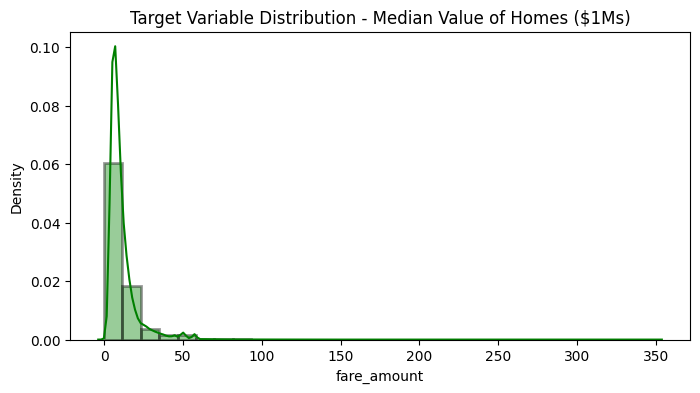

In [35]:
plt.figure(figsize=[8,4])
sns.distplot(df["fare_amount"], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)

plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

In [36]:
categorical_features

['Monthly_Quarter', 'Hourly_Segments', 'passenger_count', 'year', 'weekday']

In [37]:
categorical_column = df[['Monthly_Quarter', 'Hourly_Segments', 'weekday', 'year', 'passenger_count']]

In [38]:
categorical_column.head()

,Monthly_Quarter,Hourly_Segments,weekday,year,passenger_count
0,Q2,H5,3,2015,1.0
1,Q3,H6,4,2009,1.0
2,Q3,H6,0,2009,1.0
3,Q2,H3,4,2009,3.0
4,Q3,H5,3,2014,5.0


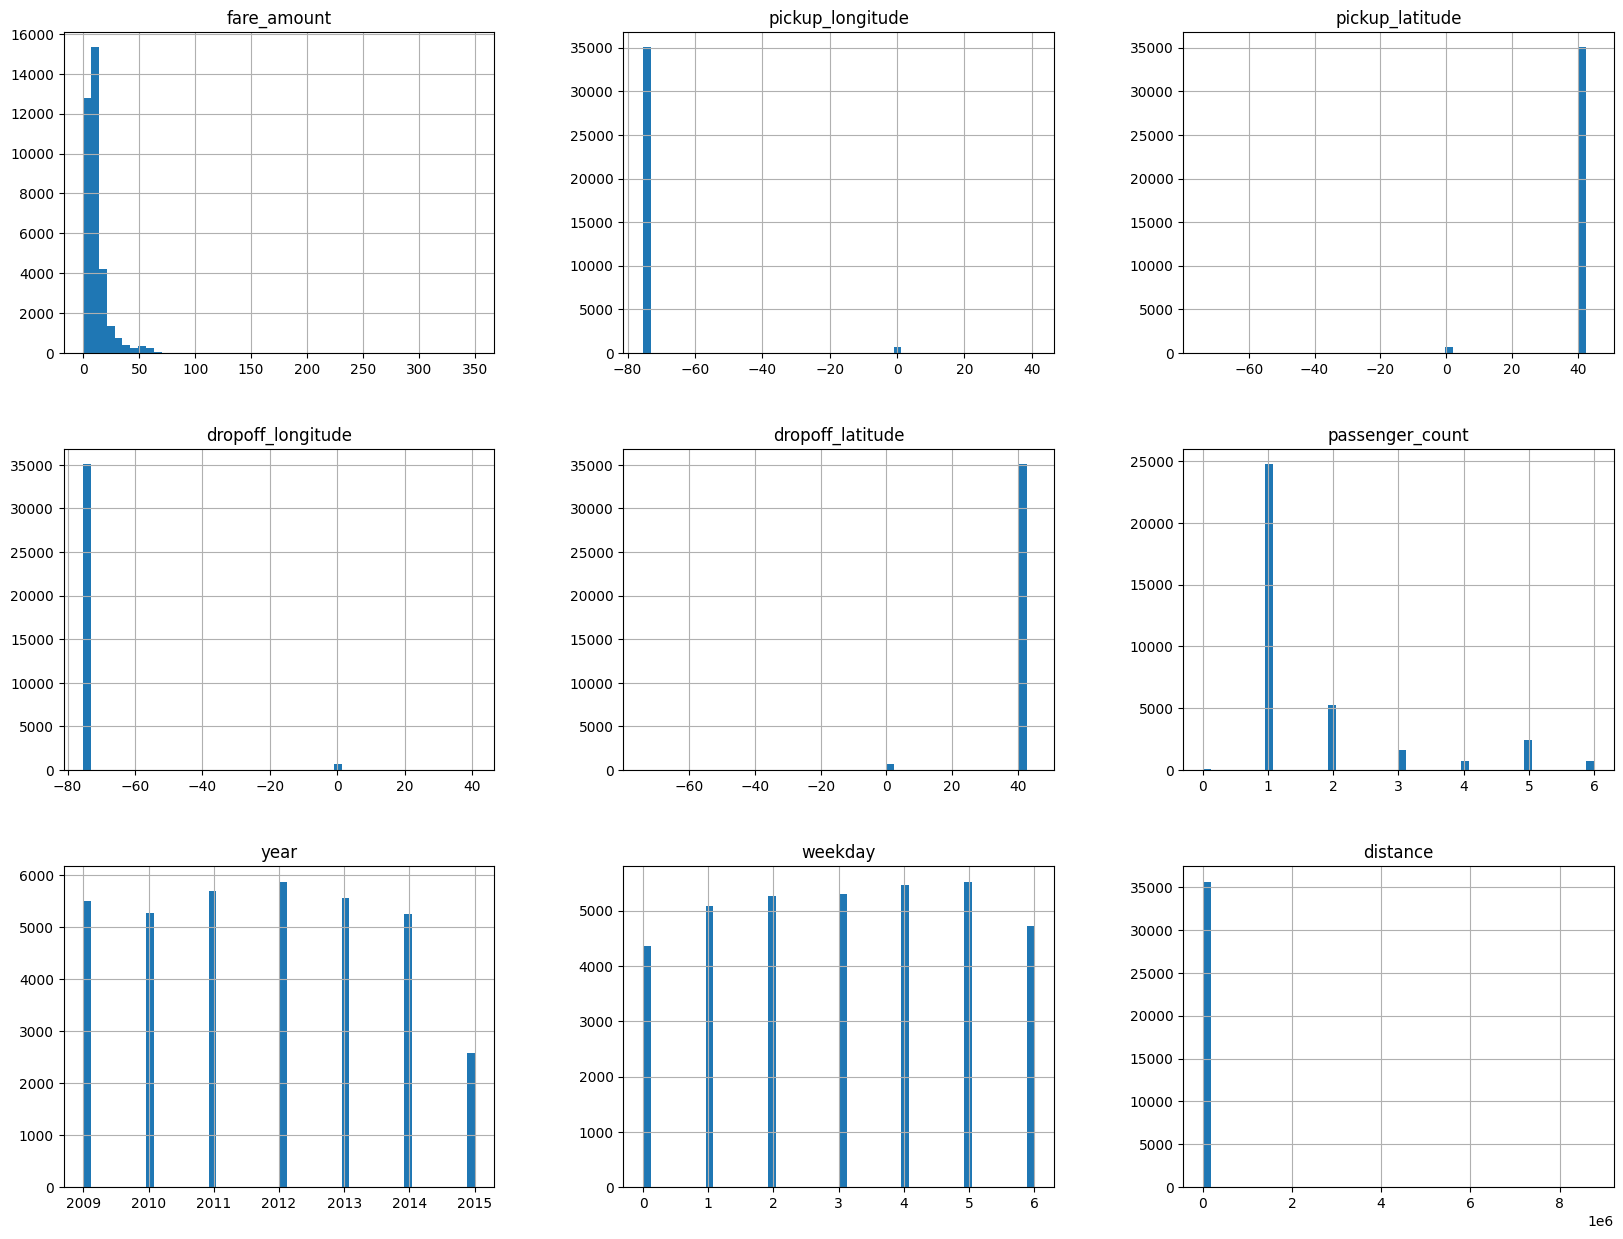

In [39]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

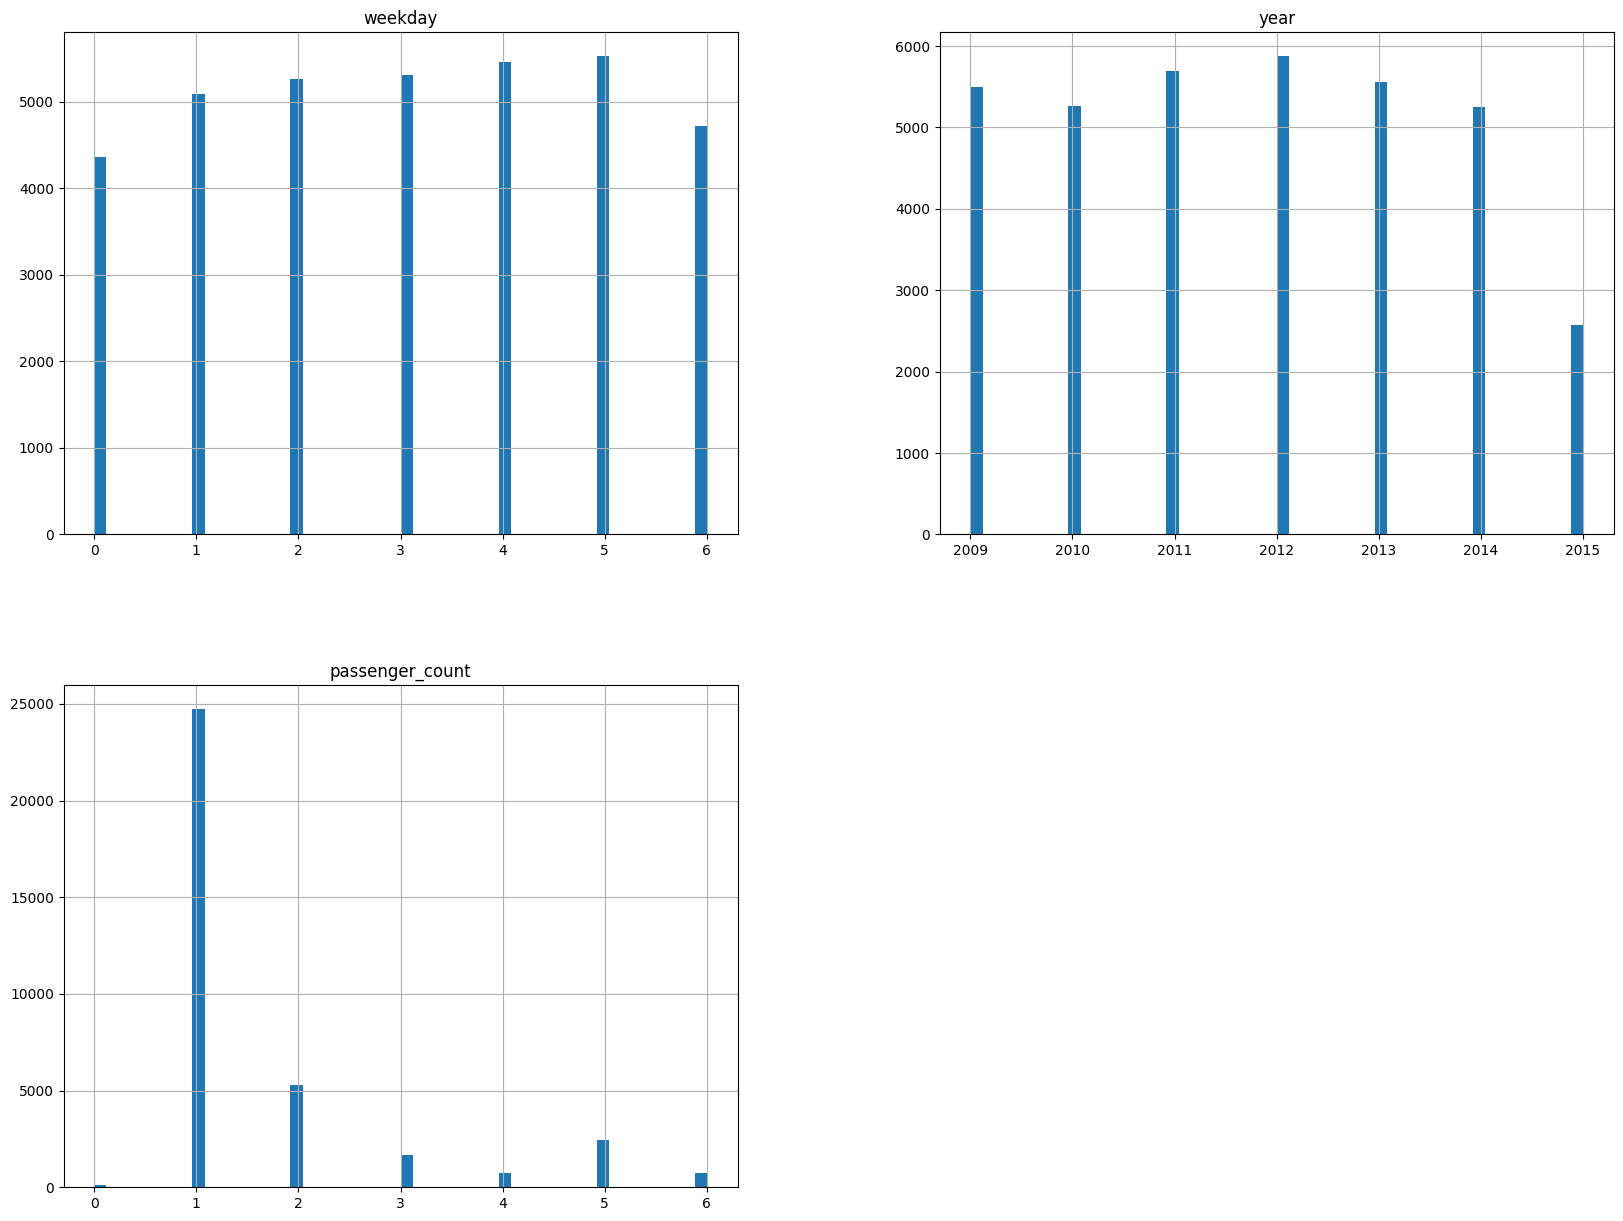

In [40]:
categorical_column.hist(bins = 50, figsize = (20,15))
plt.show()

<ipython-input-41-b5204a291b45>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Monthly_Quarter"], palette="viridis")


<Axes: xlabel='Monthly_Quarter', ylabel='count'>

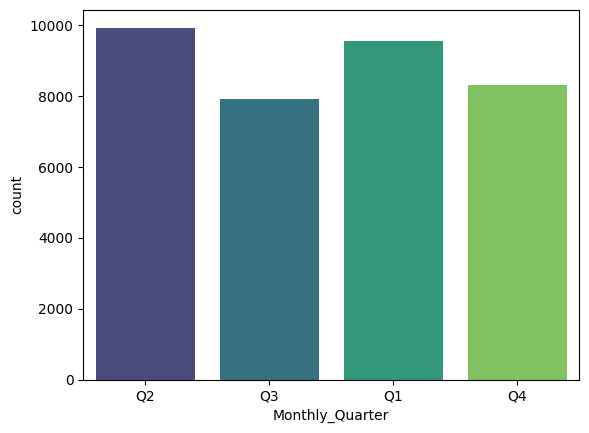

In [41]:
sns.countplot(x=df["Monthly_Quarter"], palette="viridis")

In [42]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'weekday', 'Monthly_Quarter', 'Hourly_Segments', 'distance'],
      dtype='object')

<ipython-input-43-404fdb197430>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["weekday"], palette="viridis")


<Axes: xlabel='weekday', ylabel='count'>

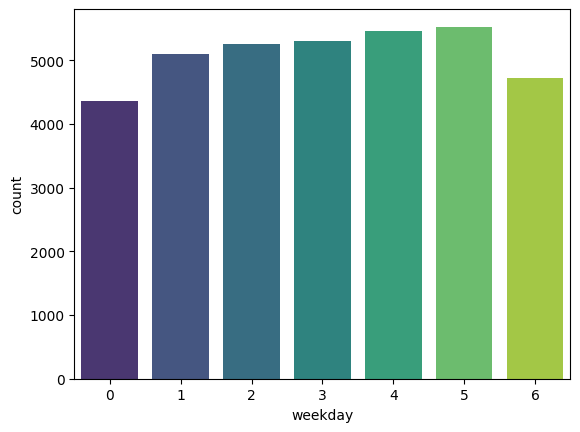

In [43]:
sns.countplot(x=df["weekday"], palette="viridis")

<ipython-input-44-b5204a291b45>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Monthly_Quarter"], palette="viridis")


<Axes: xlabel='Monthly_Quarter', ylabel='count'>

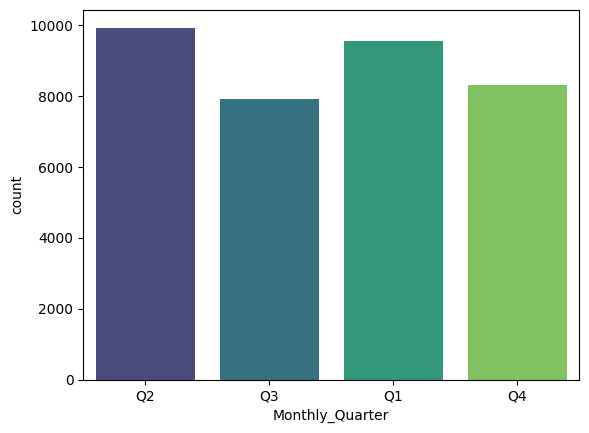

In [44]:
sns.countplot(x=df["Monthly_Quarter"], palette="viridis")

<ipython-input-45-2f226075d459>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Hourly_Segments"], palette="viridis")


<Axes: xlabel='Hourly_Segments', ylabel='count'>

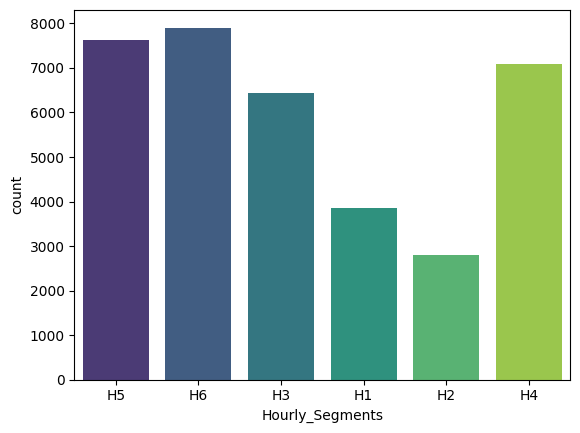

In [45]:
sns.countplot(x=df["Hourly_Segments"], palette="viridis")

<ipython-input-46-9d70a874b705>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["passenger_count"], palette="viridis")


<Axes: xlabel='passenger_count', ylabel='count'>

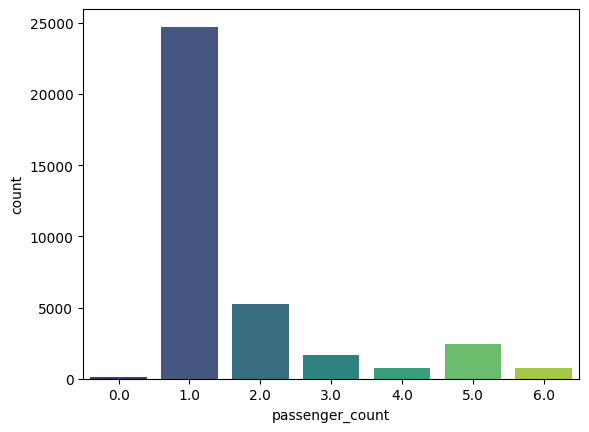

In [46]:
sns.countplot(x=df["passenger_count"], palette="viridis")

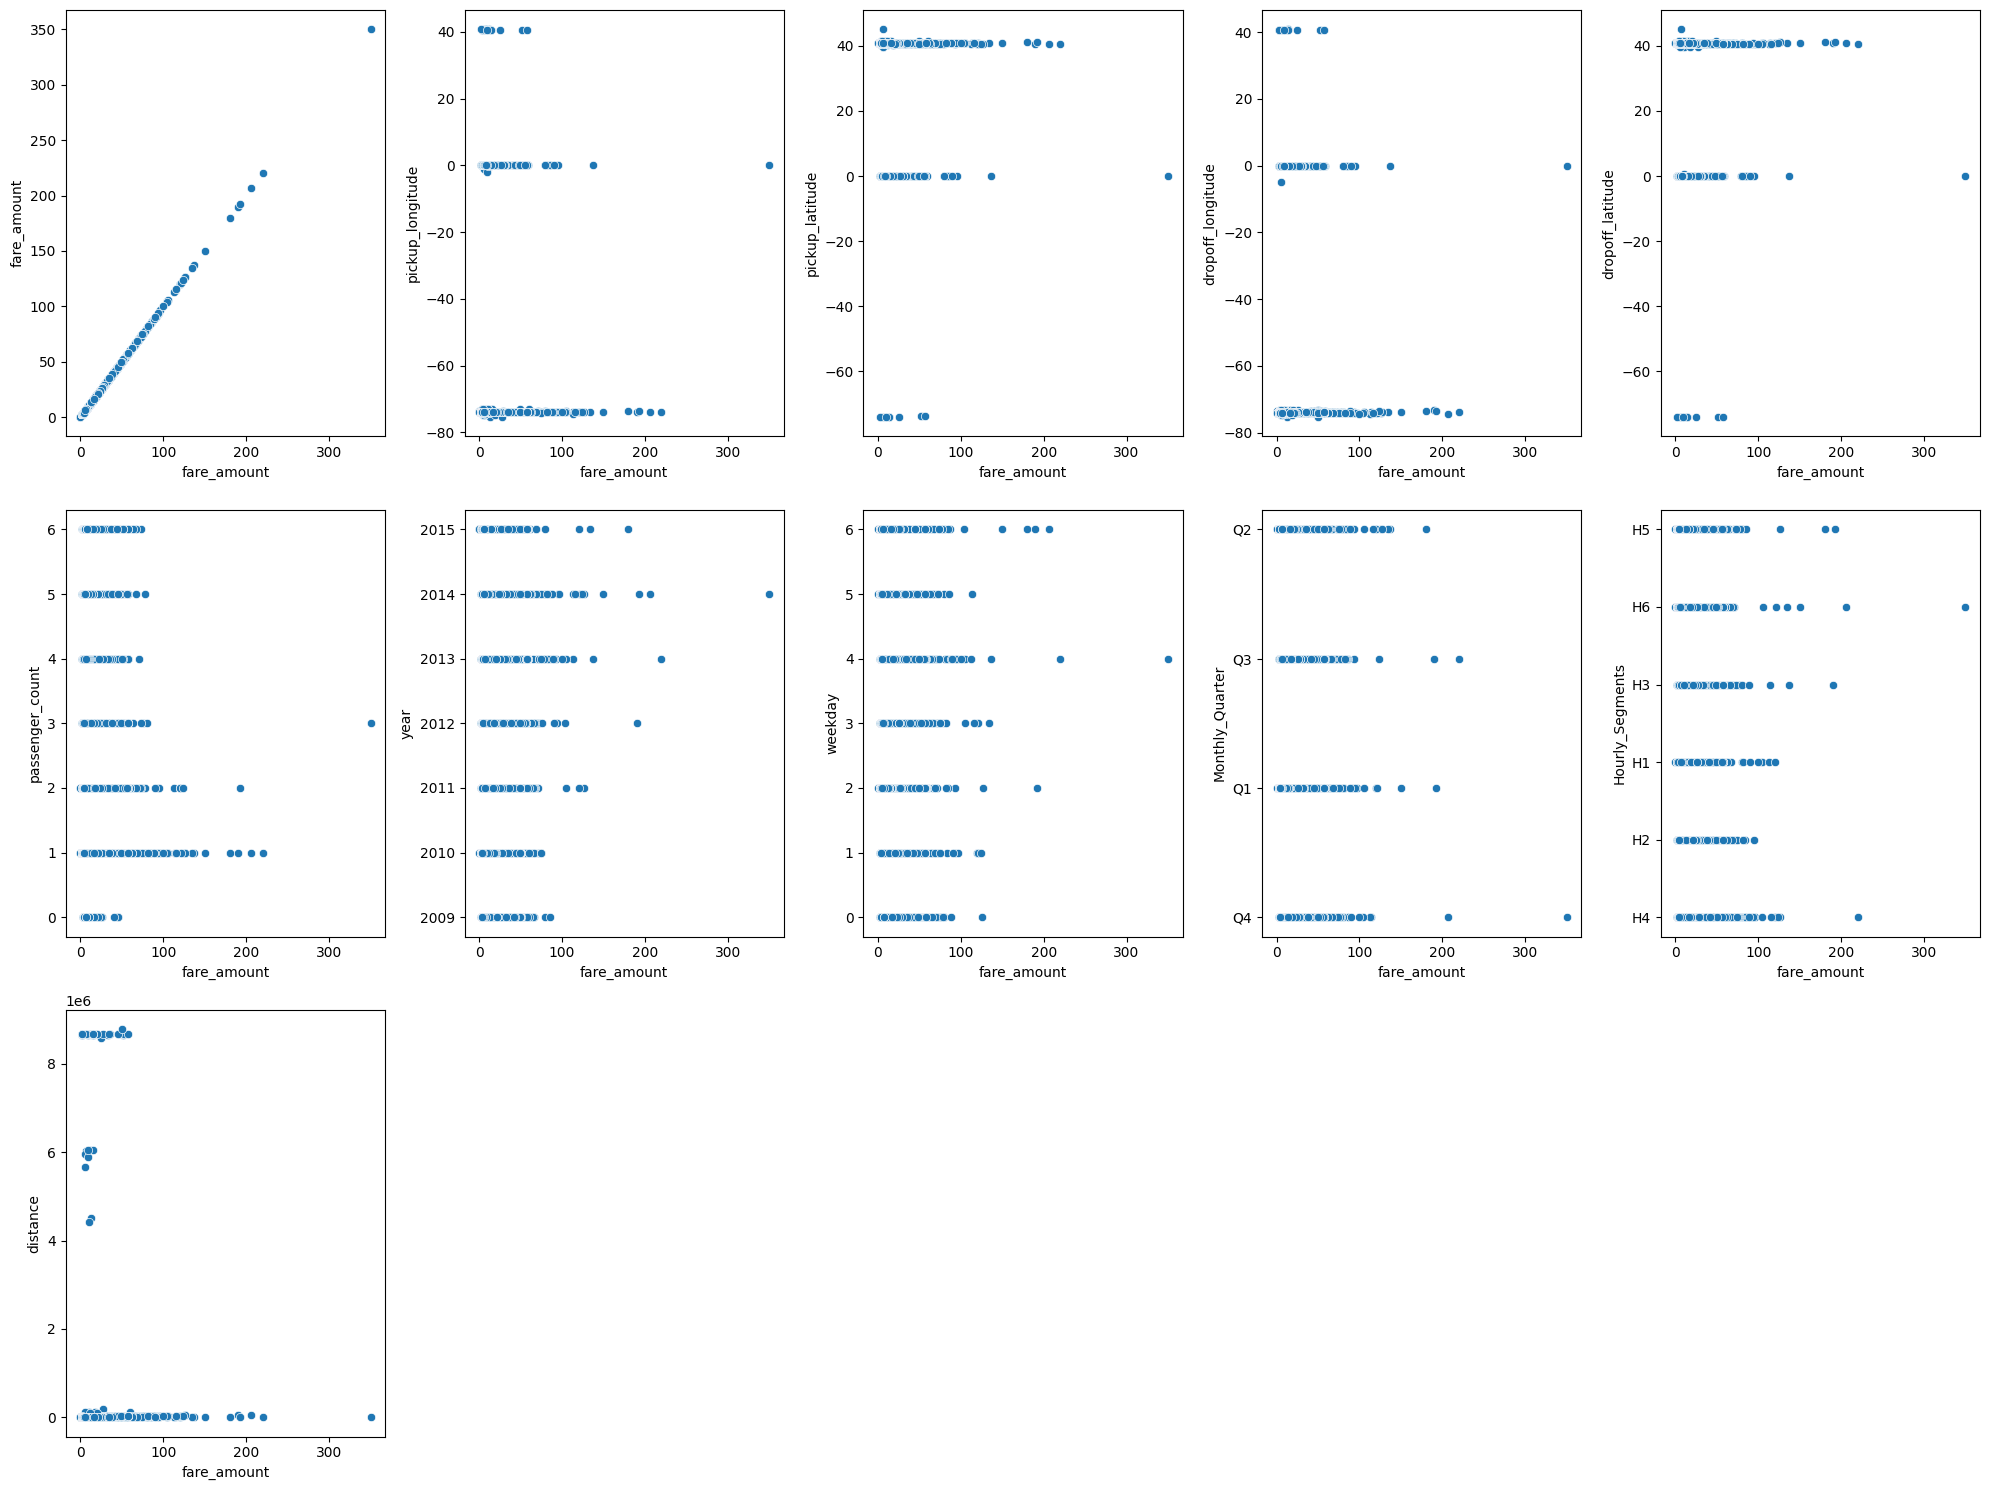

In [47]:
plt.figure(figsize=(20,15))
plotnumber = 1

for column in df:
    if plotnumber <= 24:
        ax = plt.subplot(3, 5, plotnumber)
        sns.scatterplot(x = df["fare_amount"], y = df[column])

    plotnumber += 1

plt.tight_layout()
plt.show()

<ipython-input-48-3870a5993d32>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["pickup_longitude"], shade=True)


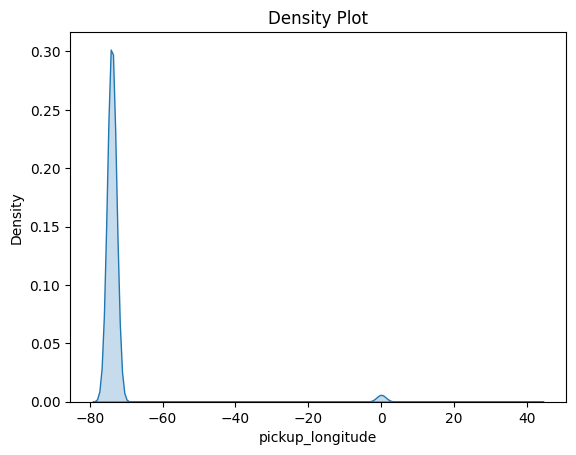

In [48]:
sns.kdeplot(df["pickup_longitude"], shade=True)
plt.title("Density Plot")
plt.xlabel("pickup_longitude")
plt.ylabel("Density")
plt.show()

<ipython-input-49-24f06ea2a6d2>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["dropoff_longitude"], shade=True)


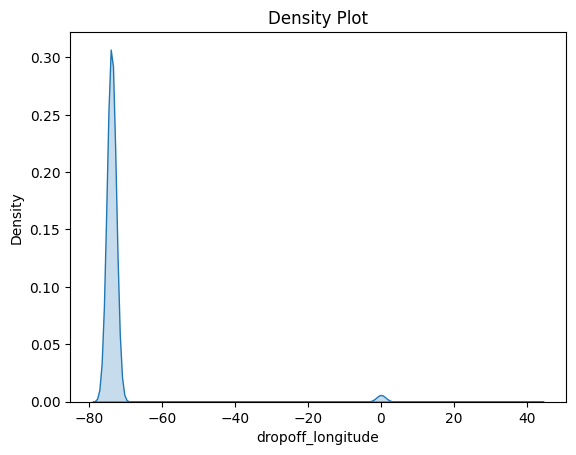

In [49]:
sns.kdeplot(df["dropoff_longitude"], shade=True)
plt.title("Density Plot")
plt.xlabel("dropoff_longitude")
plt.ylabel("Density")
plt.show()

<ipython-input-50-284290ef6d92>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["pickup_latitude"], shade=True)


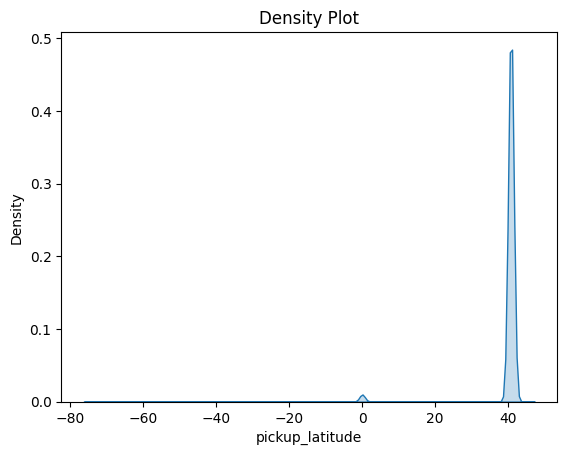

In [50]:
sns.kdeplot(df["pickup_latitude"], shade=True)
plt.title("Density Plot")
plt.xlabel("pickup_latitude")
plt.ylabel("Density")
plt.show()

<ipython-input-51-9d61178430aa>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["dropoff_latitude"], shade=True)


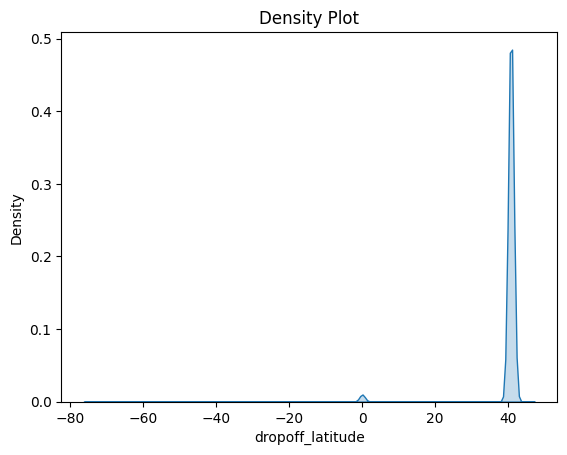

In [51]:
sns.kdeplot(df["dropoff_latitude"], shade=True)
plt.title("Density Plot")
plt.xlabel("dropoff_latitude")
plt.ylabel("Density")
plt.show()

<ipython-input-52-97bd71d4b604>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["distance"], shade=True)


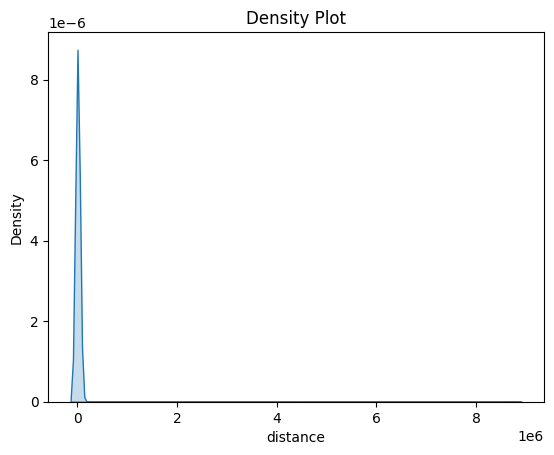

In [52]:
sns.kdeplot(df["distance"], shade=True)
plt.title("Density Plot")
plt.xlabel("distance")
plt.ylabel("Density")
plt.show()

In [53]:
df = df.copy(deep=True)

In [54]:
df.shape

(35722, 11)

In [55]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'weekday', 'Monthly_Quarter', 'Hourly_Segments', 'distance'],
      dtype='object')

In [56]:
df1 = df[["fare_amount","pickup_longitude","pickup_latitude","dropoff_longitude","dropoff_latitude","distance"]]

In [57]:
df1.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1681.11
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2454.36
2,12.9,-74.005043,40.740770,-73.962565,40.772647,5039.60
3,5.3,-73.976124,40.790844,-73.965316,40.803349,1661.44
4,16.0,-73.925023,40.744085,-73.973082,40.761247,4483.73


In [58]:
df1.shape

(35722, 6)

In [59]:
categorical_features

['Monthly_Quarter', 'Hourly_Segments', 'passenger_count', 'year', 'weekday']

In [60]:
data1 = pd.get_dummies(df,columns = ['Monthly_Quarter', 'Hourly_Segments', 'weekday', 'year', 'passenger_count'],dtype = int, drop_first=True)

In [61]:
data1.shape


(35722, 32)

<ipython-input-62-bc70a77efcd3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["fare_amount"])
<ipython-input-62-bc70a77efcd3>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["distance"])


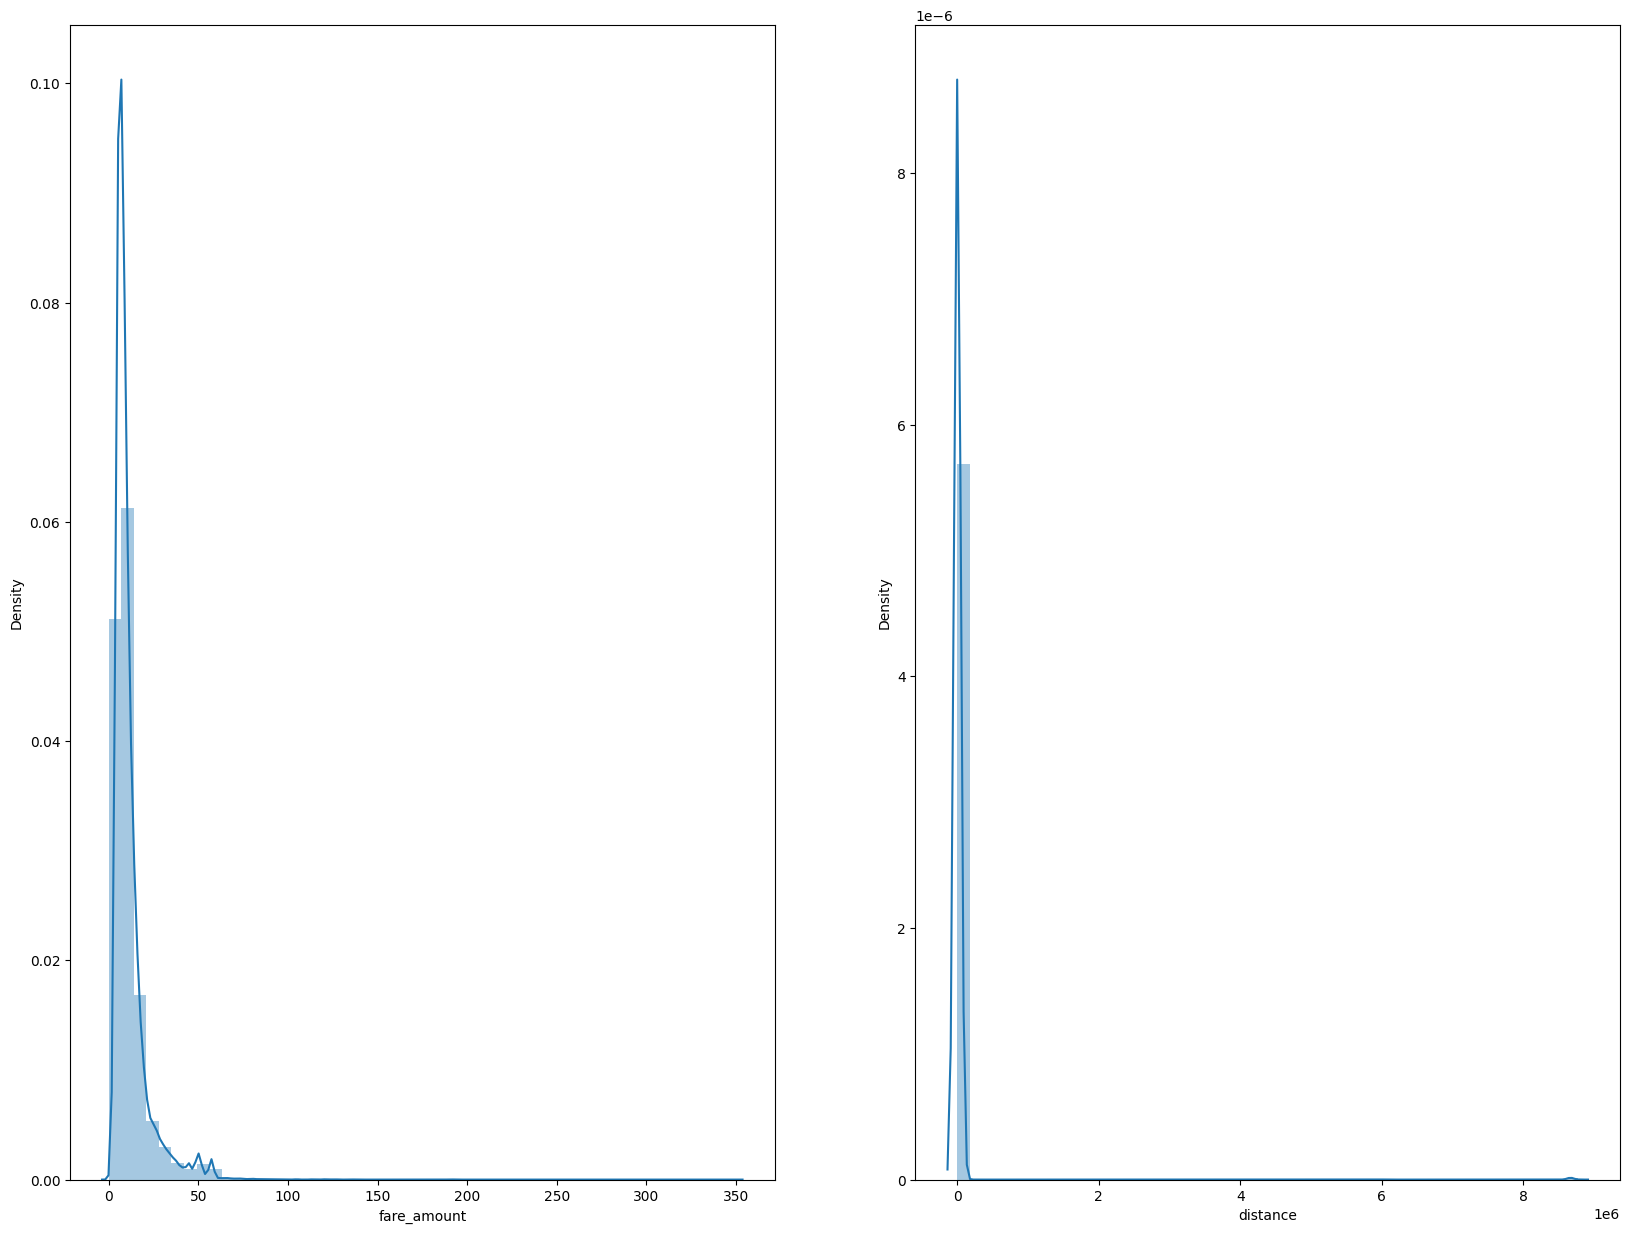

In [62]:
plt.figure(figsize = (20,15))
plt.subplot(1,2,1)
sns.distplot(data1["fare_amount"])

plt.subplot(1,2,2)
sns.distplot(data1["distance"])
plt.show()

In [63]:
#To find the skewness of this column
data1["fare_amount"].skew()

4.949031704969919

In [64]:
data1["distance"].skew()

22.936693952031288

In [65]:
data1["pickup_longitude"].skew()

7.140599350895659

In [66]:
data1["pickup_latitude"].skew()

-8.673886150046181

In [67]:
data1["dropoff_longitude"].skew()


7.175165241761905

In [68]:
data1["dropoff_latitude"].skew()

-8.683147735420205

<Axes: ylabel='fare_amount'>

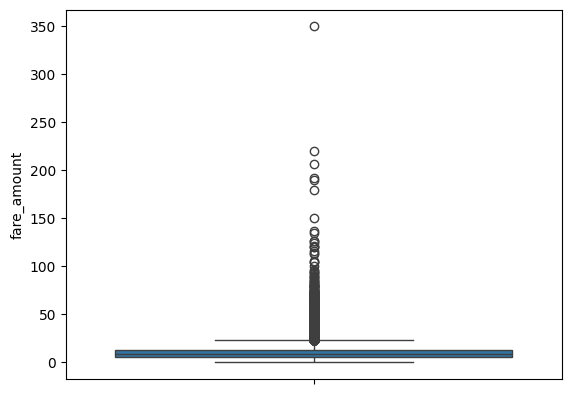

In [69]:
sns.boxplot(data1["fare_amount"])

In [70]:
data1["fare_amount"].describe()

,fare_amount
count,35722.000000
mean,11.394712
std,10.085343
min,0.000000
25%,6.000000
50%,8.500000
75%,12.900000
max,350.000000


In [71]:
data1["fare_amount"].skew()

4.949031704969919

<ipython-input-72-1c9897897e09>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["fare_amount"])


<Axes: xlabel='fare_amount', ylabel='Density'>

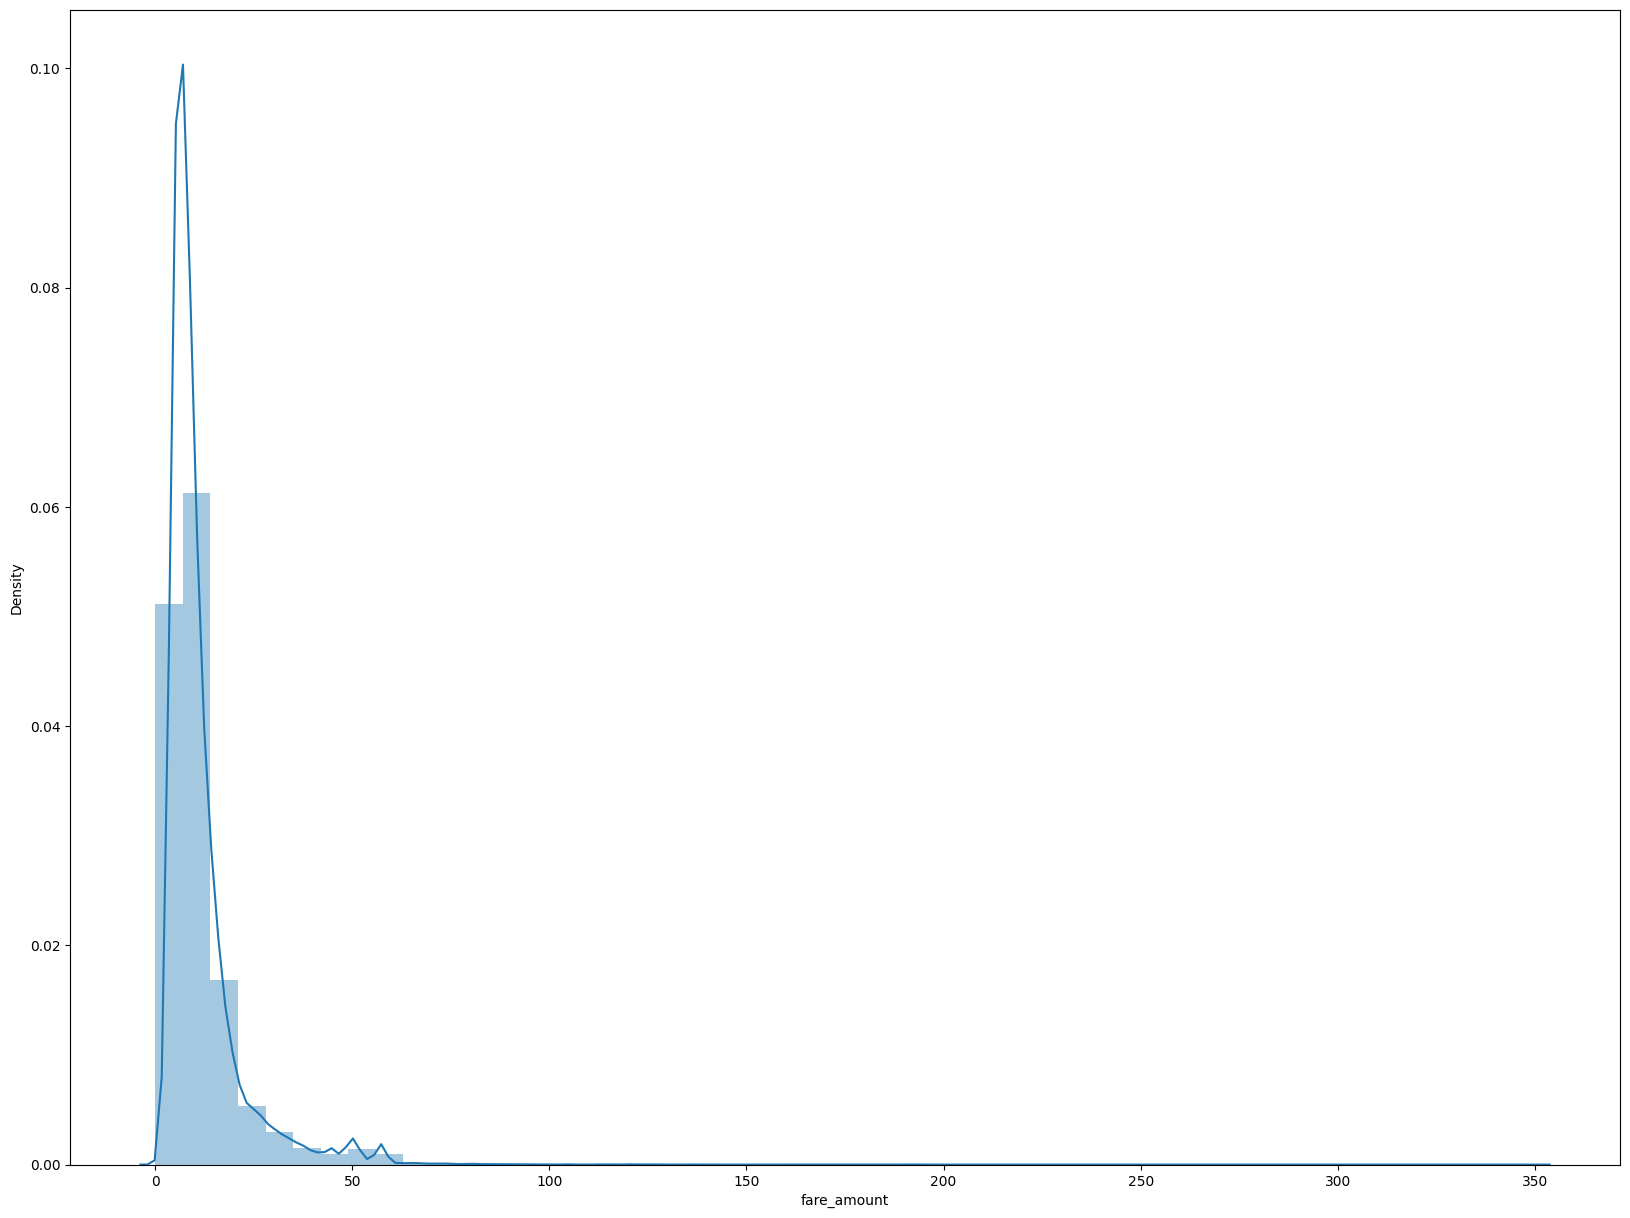

In [72]:
plt.figure(figsize = (20,15))
sns.distplot(data1["fare_amount"])

<Axes: ylabel='fare_amount'>

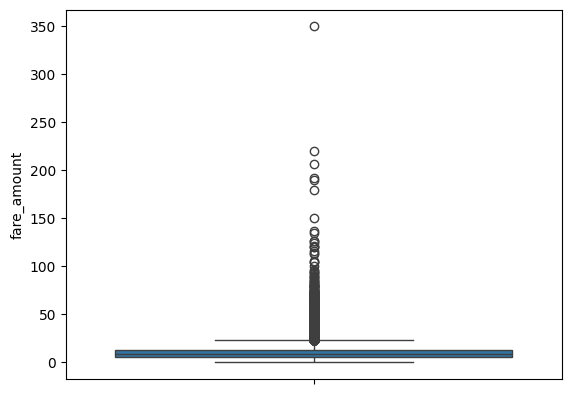

In [73]:
sns.boxplot(data1["fare_amount"])

In [74]:
percentile25 = data1["distance"].quantile(0.25)
percentile75 = data1["distance"].quantile(0.75)

In [75]:
print(percentile25)
print(percentile75)

1215.1950000000002
3893.465


In [76]:
IQR = percentile75 - percentile25

In [77]:
IQR

2678.27

In [78]:
upperlimit = percentile75 + 1.5 * IQR
lowerlimit = percentile25 - 1.5 * IQR

In [79]:
print("Upper Limit",upperlimit)
print("Lower Limit",lowerlimit)

Upper Limit 7910.87
Lower Limit -2802.2099999999996


In [80]:
data1[data1["distance"] > upperlimit]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2012,year_2013,year_2014,year_2015,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
6,24.50,-73.961447,40.693965,-73.871195,40.774297,11734.67,0,0,1,1,...,0,0,1,0,0,0,0,0,1,0
30,25.70,-73.944815,40.834367,-73.989332,40.721920,13040.42,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34,39.50,-73.788080,40.642187,-73.865042,40.725997,11355.49,1,0,0,1,...,0,0,1,0,0,0,0,1,0,0
39,29.00,-73.992600,40.753172,-73.908508,40.816192,9967.93,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
82,26.10,-73.976132,40.744211,-73.904950,40.876687,15890.26,1,0,0,0,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35664,26.00,-73.997828,40.716968,-73.883271,40.745537,10184.08,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
35670,57.54,-73.994278,40.759247,-73.783150,40.646633,21788.86,1,0,0,1,...,0,0,0,1,1,0,0,0,0,0
35682,26.00,-73.978002,40.729482,-73.934410,40.652777,9280.74,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
35683,38.50,-73.989127,40.763442,-73.872703,40.774325,9903.51,0,0,1,1,...,1,0,0,0,0,0,1,0,0,0


In [81]:
data1[data1["distance"] < lowerlimit]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2012,year_2013,year_2014,year_2015,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0


In [82]:
data1 = data1.drop(data1[data1["distance"] > upperlimit].index)

In [83]:
data1 .shape

(32841, 32)

In [84]:
data1["distance"].skew()

1.056276404419902

<ipython-input-85-dfbb1b00b0ca>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["distance"])


<Axes: xlabel='distance', ylabel='Density'>

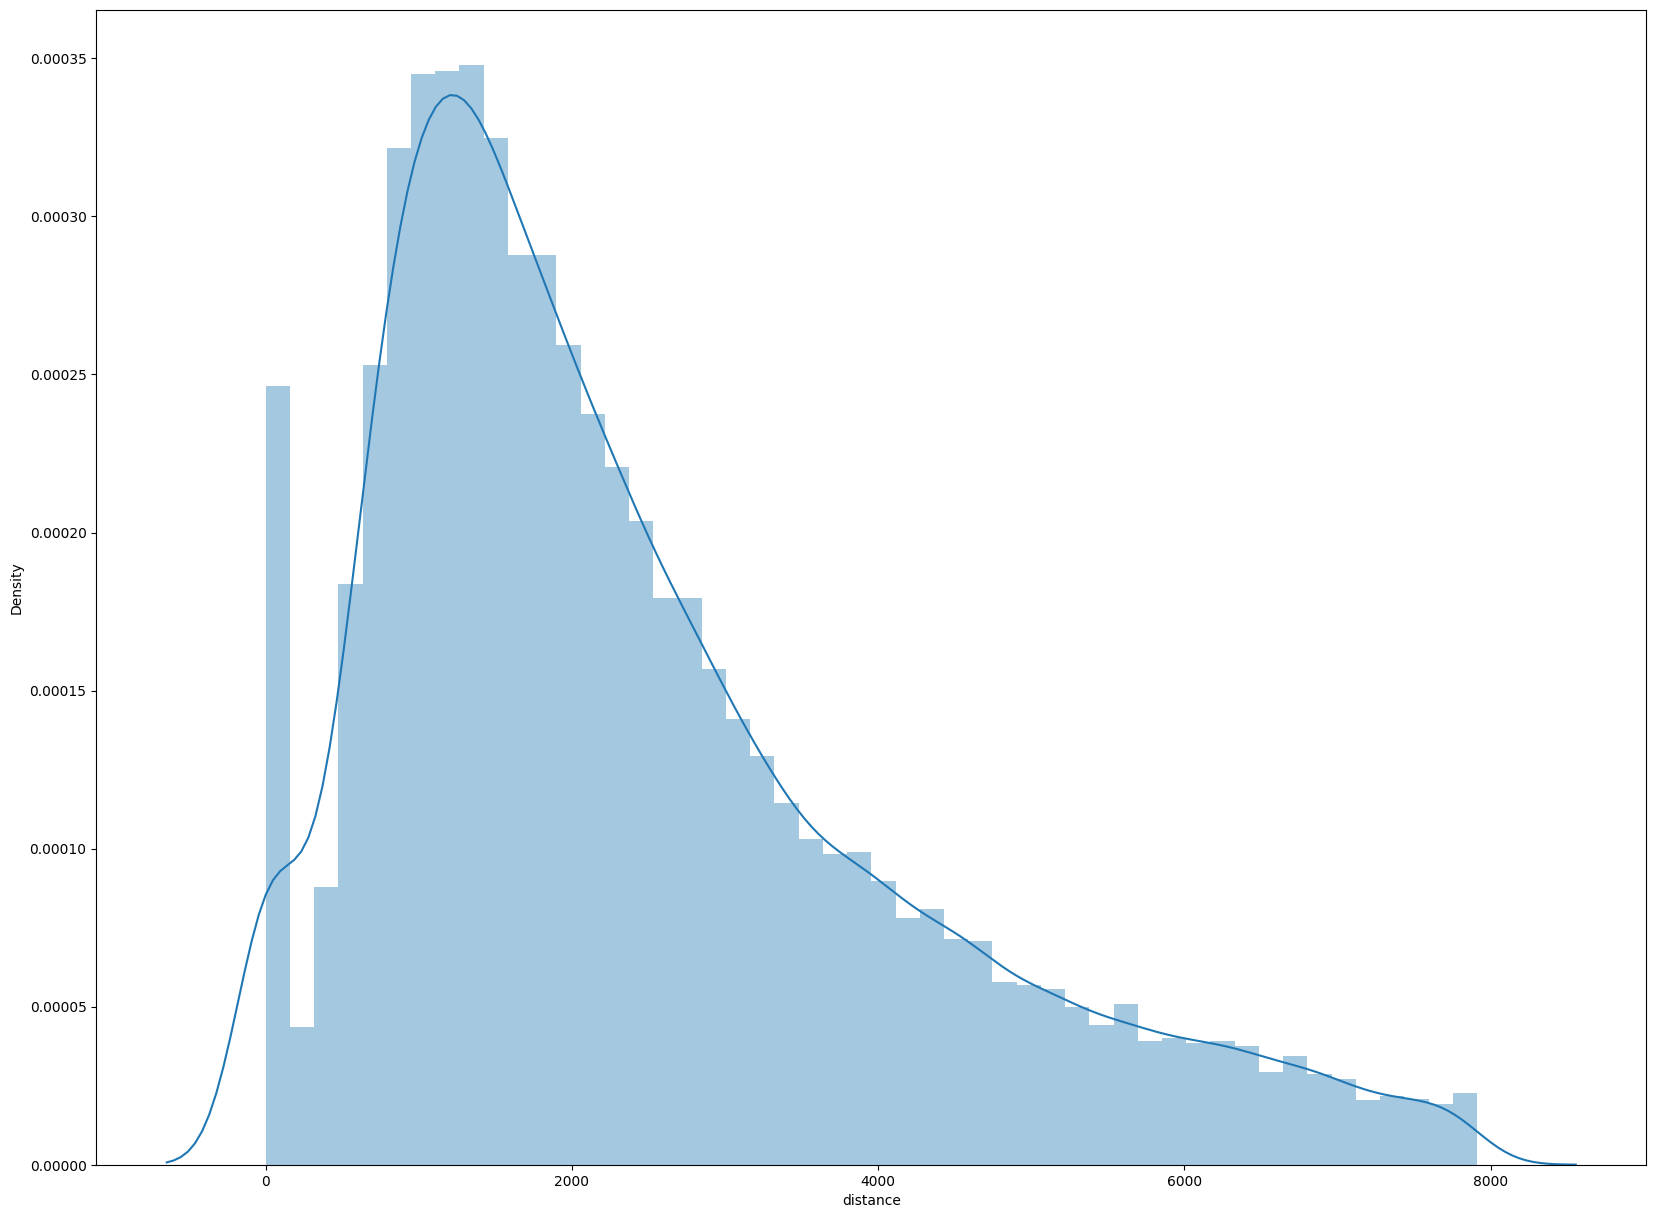

In [85]:
plt.figure(figsize = (20,15))
sns.distplot(data1["distance"])

<Axes: ylabel='distance'>

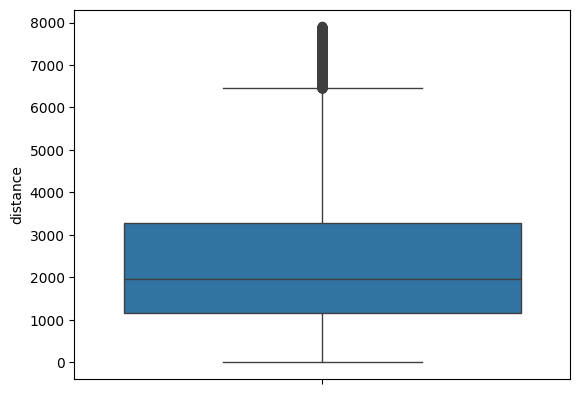

In [86]:
sns.boxplot(data1["distance"])

In [87]:
data1.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance',
       'Monthly_Quarter_Q2', 'Monthly_Quarter_Q3', 'Monthly_Quarter_Q4',
       'Hourly_Segments_H2', 'Hourly_Segments_H3', 'Hourly_Segments_H4',
       'Hourly_Segments_H5', 'Hourly_Segments_H6', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'year_2010',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'passenger_count_1.0', 'passenger_count_2.0', 'passenger_count_3.0',
       'passenger_count_4.0', 'passenger_count_5.0', 'passenger_count_6.0'],
      dtype='object')

In [88]:
data1["pickup_longitude"].skew()

7.046176519715496

In [89]:
percentile25 = data1["pickup_longitude"].quantile(0.25)
percentile75 = data1["pickup_longitude"].quantile(0.75)

In [90]:
print(percentile25)
print(percentile75)

-73.99229
-73.968875


In [91]:
IQR = percentile75 - percentile25


In [92]:
IQR

0.023414999999999964

In [93]:
upperlimit = percentile75 + 1.5 * IQR
lowerlimit = percentile25 - 1.5 * IQR

In [94]:
print(upperlimit)
print(lowerlimit)

-73.9337525
-74.0274125


In [95]:
data1[data1["pickup_longitude"] > upperlimit]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2012,year_2013,year_2014,year_2015,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
4,16.00,-73.925023,40.744085,-73.973082,40.761247,4483.73,0,1,0,0,...,0,0,1,0,0,0,0,0,1,0
7,2.50,0.000000,0.000000,0.000000,0.000000,0.00,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
11,8.50,0.000000,0.000000,0.000000,0.000000,0.00,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
65,6.00,0.000000,0.000000,0.000000,0.000000,0.00,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
92,6.10,0.000000,0.000000,0.000000,0.000000,0.00,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35466,9.30,0.000000,0.000000,0.000000,0.000000,0.00,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
35468,7.70,0.000000,0.000000,0.000000,0.000000,0.00,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
35602,9.50,40.733055,-73.975378,40.773677,-73.951673,2927.42,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
35616,8.50,0.000000,0.000000,0.000000,0.000000,0.00,1,0,0,1,...,0,1,0,0,0,1,0,0,0,0


In [96]:
data1[data1["pickup_longitude"] < lowerlimit]

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance,Monthly_Quarter_Q2,Monthly_Quarter_Q3,Monthly_Quarter_Q4,Hourly_Segments_H2,...,year_2012,year_2013,year_2014,year_2015,passenger_count_1.0,passenger_count_2.0,passenger_count_3.0,passenger_count_4.0,passenger_count_5.0,passenger_count_6.0
457,11.7,-74.030417,40.807683,-74.027813,40.806813,240.03,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
696,5.3,-74.689831,40.190564,-74.689831,40.190564,0.00,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1948,5.3,-74.072325,40.709167,-74.073618,40.709117,109.40,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3235,13.3,-74.043873,40.633073,-74.029468,40.640817,1491.47,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4679,12.9,-75.342904,40.646965,-75.350437,40.686877,4477.72,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6883,4.9,-74.040743,40.708125,-74.040743,40.708125,0.00,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
7523,7.3,-74.102150,40.764943,-74.099925,40.760415,536.78,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
9301,46.0,-74.038116,40.713008,-74.038116,40.713008,0.00,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
11102,80.0,-74.038542,40.737570,-74.038543,40.737567,0.34,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
11301,113.0,-74.468770,40.476630,-74.468772,40.476630,0.17,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0


In [97]:
data1 = data1.drop(data1[data1["pickup_longitude"] > upperlimit].index)


In [98]:
data1 = data1.drop(data1[data1["pickup_longitude"] < lowerlimit].index)

In [99]:
data1.shape

(31461, 32)

In [100]:
data1["pickup_longitude"].skew()

0.2769034504886114

<ipython-input-101-72e04f5d9ca3>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data1["pickup_longitude"])


<Axes: xlabel='pickup_longitude', ylabel='Density'>

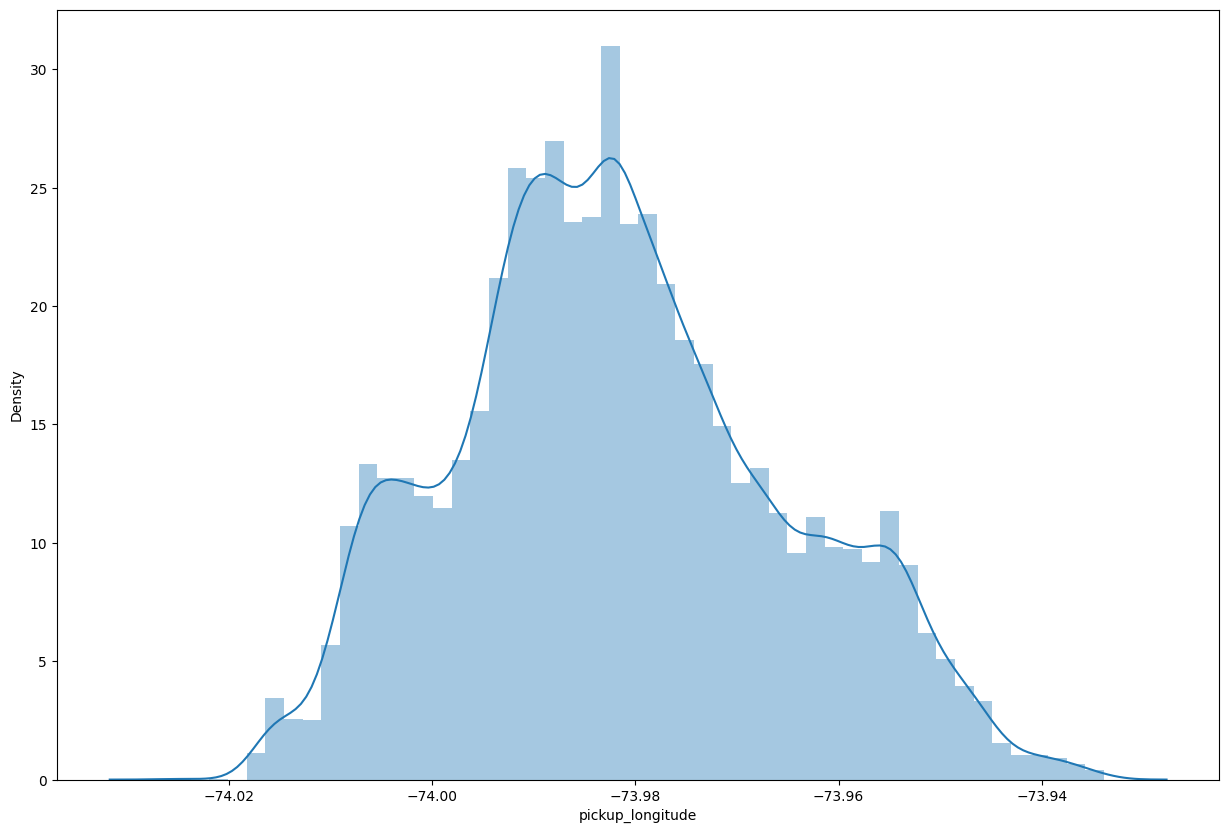

In [101]:
plt.figure(figsize = (15,10))
sns.distplot(data1["pickup_longitude"])

<Axes: ylabel='pickup_longitude'>

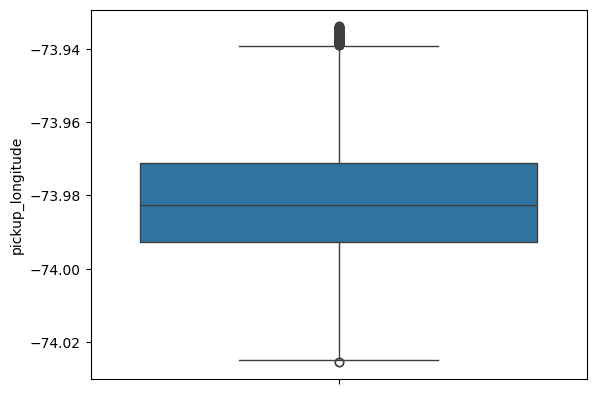

In [102]:
sns.boxplot(data1["pickup_longitude"])

In [103]:
percentile25 = data1["pickup_latitude"].quantile(0.25)
percentile75 = data1["pickup_latitude"].quantile(0.75)

In [104]:
print(percentile25)
print(percentile75)

40.737093
40.766597


In [105]:
m = []

for i in data1.columns.values:
    m.append(i.replace(" ","_"))

data1.columns = m

X = data1.drop(["fare_amount"],axis = 1)
y = data1["fare_amount"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)

print(X.shape,y.shape,X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(31461, 31) (31461,) (25168, 31) (6293, 31) (25168,) (6293,)


In [106]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [ ]:
X_train_std

array([[-6.15485972e-01, -1.11881245e-01, -3.14690771e-01, ...,
        -2.73267234e-01, -1.48250724e-01, -2.75229474e-03],
       [-1.40105706e+00, -4.08282321e-01, -5.55900482e-01, ...,
        -2.73267234e-01, -1.48250724e-01, -2.75229474e-03],
       [ 4.37983107e-01,  1.72825973e+00, -1.21521950e-01, ...,
        -2.73267234e-01, -1.48250724e-01, -2.75229474e-03],
       ...,
       [-2.46679331e-01,  3.26668377e-01, -6.02354118e-01, ...,
        -2.73267234e-01, -1.48250724e-01, -2.75229474e-03],
       [-7.51900985e-02, -1.83876928e-01, -1.81996331e-01, ...,
        -2.73267234e-01, -1.48250724e-01, -2.75229474e-03],
       [-7.69715324e-01, -9.95179069e-01, -5.58704631e-01, ...,
         3.65942153e+00, -1.48250724e-01, -2.75229474e-03]])

In [ ]:
X_test_std


array([[-0.43364081,  0.03206824,  0.69628426, ..., -0.27326723,
        -0.14825072, -0.00275229],
       [ 0.82109079,  0.60204454, -0.82933145, ..., -0.27326723,
        -0.14825072, -0.00275229],
       [-0.10354561,  0.16173586, -0.50817704, ..., -0.27326723,
        -0.14825072, -0.00275229],
       ...,
       [-0.73969546, -0.43416559, -0.0155992 , ..., -0.27326723,
        -0.14825072, -0.00275229],
       [-0.06933407, -0.54850428,  0.1992621 , ..., -0.27326723,
        -0.14825072, -0.00275229],
       [ 0.3647519 ,  0.12374861, -0.46897187, ..., -0.27326723,
        -0.14825072, -0.00275229]])

In [107]:
lr = LinearRegression()

In [108]:
lr.fit(X_train_std, y_train)

LinearRegression()

In [109]:
print("Train Accuracy", lr.score(X_train_std,y_train))
print("Test Accuracy", lr.score(X_test_std,y_test))

Train Accuracy 0.546472258481308
Test Accuracy 0.5620090148393357


In [110]:
# Ridge
ridge = Ridge(random_state=0,alpha=0.1)

In [111]:
ridge.fit(X_train,y_train)

Ridge(alpha=0.1, random_state=0)

In [112]:
print("Train Accuracy",ridge.score(X_train,y_train))
print("Test Accuracy", ridge.score(X_test,y_test))

Train Accuracy 0.5464700387149195
Test Accuracy 0.5620484365013075


In [113]:
from sklearn.datasets import make_regression
X,y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)

In [114]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=100)

In [115]:
rf = RandomForestRegressor(max_depth=11, random_state=0)

In [116]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=11, random_state=0)

In [117]:
print("Train Accuracy", rf.score(X_train,y_train))
print("Test Accuracy", rf.score(X_test,y_test))

Train Accuracy 0.9900316636942278
Test Accuracy 0.9473084711151801


In [118]:
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE

In [119]:
xgb_r = xg.XGBRegressor(objective ='reg:linear', max_depth = 6,
                        max_leaf_nodes = 2,
                        n_estimators = 165, seed = 123)

In [120]:
xgb_r.fit(X_train,y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:47:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:47:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "max_leaf_nodes" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaf_nodes=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=165,
             n_jobs=None, num_parallel_tree=None, ...)

In [121]:
y_pred = xgb_r.predict(X_test)

In [122]:
y_pred

array([-35.651592  , -61.621086  ,  36.388824  ,   6.3249397 ,
       -12.694076  ,  -3.0274062 ,  59.47407   , -18.183739  ,
        11.017796  ,  81.4349    ,   3.84164   , -20.389973  ,
       -38.96638   ,   0.94764614, -41.223186  , -42.9405    ,
        53.885746  , -13.113141  ,  57.687923  , -21.904516  ],
      dtype=float32)

In [123]:
# RMSE Computation
rmse = np.sqrt(MSE(y_test, y_pred))
print("RMSE : % f" %(rmse))

RMSE :  8.616447


In [124]:
print("Train Accuracy",xgb_r.score(X_train,y_train))
print("Test Accuracy", xgb_r.score(X_test,y_test))

Train Accuracy 0.9999999991572491
Test Accuracy 0.9629371637511809


In [150]:
!pip install streamlit
!npm install localtunnel

⠙⠹⠸⠼⠴
up to date, audited 23 packages in 767ms
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠴

In [159]:
import streamlit as st
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import pickle

# ... (Load and preprocess data, as before) ...

# Model training
model = RandomForestRegressor(max_depth=11, random_state=0)
model.fit(X, y)

# Save the model to a pickle file
with open('uber_fare_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# ... (Rest of the Streamlit app code) ...

In [160]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import pickle

# Load the model from the pickle file
with open('uber_fare_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Streamlit app
st.title("Uber Fare Prediction")

# Input fields
pickup_longitude = st.number_input("Pickup Longitude", value=-73.9735)  # Example default value
pickup_latitude = st.number_input("Pickup Latitude", value=40.7830)  # Example default value
dropoff_longitude = st.number_input("Dropoff Longitude", value=-73.9735)  # Example default value
dropoff_latitude = st.number_input("Dropoff Latitude", value=40.7830)  # Example default value



# Prediction
if st.button("Predict Fare"):
    # Create input data
    # Indented this block of code to be executed when the button is clicked
    input_data = pd.DataFrame([[pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude]])
    input_data.columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

    # Make prediction
    # Indented this line as well
    prediction = model.predict(input_data)[0]

    # Indented this line as well
    st.write(f"Predicted Fare: ${prediction:.2f}")

Overwriting app.py


In [161]:
!streamlit run run.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: run.py


In [162]:
!wget -q -O - ipv4.icanhazip.com

34.143.245.215


In [163]:
! streamlit run app.py & npx localtunnel --port 8501



⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.143.245.215:8501

your url is: https://wet-donuts-follow.loca.lt
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages